# Week 12

Neural Networks for images

In [2]:
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/data_utils.py
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/image_utils.py

!wget -qO- https://github.com/DM-GY-9103-2024F-H/9103-utils/releases/latest/download/lfw.tar.gz | tar xz

In [3]:
import torch

from torch import Tensor, nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2

from data_utils import classification_error, display_confusion_matrix
from image_utils import make_image

from WK12_utils import LFWUtils

### Images

Can we use NN models to do classification of images? Sure.

The steps are the same, we just have to load image data and adapt the cost/loss function to calculate some kind of classification metric instead.

We'll use the _Labeled Faces in the Wild_ dataset from last homework.

The steps for setting up the classification model will be:

- Load dataset and do any kind of pre-processing
- Split data into train/test datasets
- Split independent features and classification label and load them into `Tensors`
- Create `DataLoader` instances (we'll see what this means below)
- Build a NN model
- Set up an optimizer
- Pick a cost/loss function
- Implement an evaluation function and any other kind of visualization that helps quantify the model
- Train model
- Evaluate

### Load and split Dataset

The `LFWUtils.train_test_split(0.5)` function gives us some `Python` objects we can use to create our `Tensor`s.

The `pixels` key gives us a list of the images' pixel data, and the `label` key gives us the images' label IDs.

We don't have to do any normalization since the pixels will be in a know, well-defined range of $[0 \text{ - } 255]$.

The only thing we have to do differently is cast the labels `Tensor` to `long`. This is to ensure the numbers in those `Tensor`s are whole numbers and don't have decimal points.

In [4]:
train, test = LFWUtils.train_test_split(0.5)

x_train = Tensor(train["pixels"])
y_train = Tensor(train["labels"]).long()

x_test = Tensor(test["pixels"])
y_test = Tensor(test["labels"]).long()

print("Dataset Samples")
print("\tTrain:", len(x_train))
print("\tTest:", len(x_test))

print("\nDataset Shape:", list(x_train.shape))
print("\nSample Shape:", list(x_train[0].shape))

Dataset Samples
	Train: 445
	Test: 438

Dataset Shape: [445, 22100]

Sample Shape: [22100]


### Look at data

We can visualize some of the images, their text labels and label IDs

0 annan


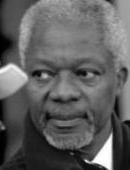

4 bushgw


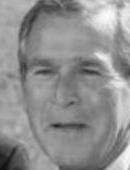

10 giuliani


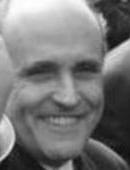

17 powell


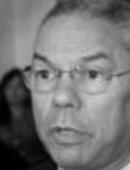

22 watts


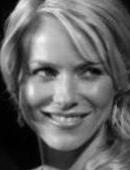

In [5]:
for idx in range(0, len(train["pixels"]), 100):
  id = train["labels"][idx]
  print(id, LFWUtils.LABELS[id])
  display(make_image(train["pixels"][idx], width=130))

### Datasets & DataLoaders

This is new !

We could try to train this neural network exactly how we trained the previous one where we gave the model the entire training dataset at once and asked for it to minimize the cost function over all of the samples at the same time.

This could work for this dataset, but once we start working with bigger and bigger datasets, it will be difficult to ask the computer to perform this kind of optimization over all of the images at the same time.

We have to split up our dataset into batches, and ask the model to work on subsets of our datasets. Since we're not giving the model all of the data at once, we should also randomize the order of the data to make sure the order in which the model sees a sample doesn't affect its influence on the overall quality of the model.

We'll use `PyTorch`'s built in [Datasets and DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) classes to help us manage our batches of training data.

### Define a Dataset Class

The first thing we have to do is define a `PyTorch` `Dataset` class that will handle our pixel and label data.

This class need to have $3$ functions defined:

`__init__()`: the constructor. Should receive all the info from a dataset.

`__len__()`: this returns how many items we have in out dataset.

`__getitem__()`: given an index, return the corresponding pixels and label.

In [7]:
class FaceDataset(Dataset):
  def __init__(self, imgs, labels):
    self.imgs = imgs
    self.labels = labels

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return [self.imgs[idx], self.labels[idx]]

### Create DataLoaders

Now we can just create `Dataset` instances for each of our $2$ datasets, and pass those along to the `DataLoader` constructor.

In the `DataLoader` constructor we can use the `batch_size` parameter to define how many images the model should consider each time it does gradient descent, and the `shuffle` parameter to specify whether the data should be randomized during that process.

Setting parameters for the training `DataLoader` is more important since the batch size and randomization will directly affect the quality of the model.

For the test `DataLoader` the batch size won't really make a difference in the results, although larger batches should evaluate faster, and shuffling might confuse us when we try to look at specific test cases that are failing.

In [8]:
train_dataloader = DataLoader(FaceDataset(x_train, y_train), batch_size=128, shuffle=True)
test_dataloader = DataLoader(FaceDataset(x_test, y_test), batch_size=512)

### Check `DataLoader`

When we iterate through a `DataLoader` with a for loop, we get a sub-section of our dataset called a `batch`.

Since the `__getitem__()` function of our `FaceDataset` class returns a list of $2$ things (pixels and a label), the `batch` in our `DataLoader` will also have collections of those $2$ things.

In [9]:
for batch in train_dataloader:
  print(batch[0].shape, batch[1].shape)

torch.Size([128, 22100]) torch.Size([128])
torch.Size([128, 22100]) torch.Size([128])
torch.Size([128, 22100]) torch.Size([128])
torch.Size([61, 22100]) torch.Size([61])


In [10]:
for imgs, labels in test_dataloader:
  print(imgs.shape, labels.shape)

torch.Size([438, 22100]) torch.Size([438])


### Model, Optimizer and Cost Function

We'll start with the simplest kind of network again, with just an input and an output layer.

The input layer has as many neurons as the number of pixels in each image, and the output layer has one neuron per possible class.

It looks like this, and is juts like our regression network above, but has more output neurons:

<img src="./imgs/linear_22100x26.jpg" width="800px"/>

Our optimizer will be `SGD` again. Depending on the dataset and model being created, `SGD` can perform even better with batched inputs because it is looking at less data and is less constrained within each batch.

Our cost function is a bit different. Previously, we used $L2$ distances to calculate the root mean square error of our regression predictions and used that value as the cost function for gradient descent.

In order to use gradient descent for classification, we have to turn the discrete nature of our labels/classes and their errors into something that has smooth and integratable slopes.

That's what the `CrossEntropyLoss()` function does for us. It looks at the outputs of our model and transforms the regression-type continuous values at our outputs into class prediction probabilities in a way that gradient descent still works.

There's more information in the [`PyTorch` documentation](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [11]:
model = nn.Linear(x_train.shape[1], len(y_train.unique()))

learning_rate = 1e-6
optim = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

loss_fn = nn.CrossEntropyLoss()

### Test Shapes

In [12]:
img, label = next(iter(train_dataloader))
out = model(img)

print("Input shape:", img.shape)
print("Output shape:", out.shape)

Input shape: torch.Size([128, 22100])
Output shape: torch.Size([128, 25])


### Train the Model

We can train the model now.

We still don't have an evaluation function, but we can use the values from the loss function to adjust parameters and make sure that the model is learning.

We'll train for $32$ epochs, and in each epoch we have to iterate through the data that is inside our `DataLoader` object.

The `x` and `y` variables below actually hold pixel and label information for $256$ images. For each of these batches we predict labels, calculate loss, calculate the slope of the loss function, update model parameters, zero the gradients, and repeat.

In [13]:
for e in range(32):
  for imgs, labels in train_dataloader:
    # clear slopes in optimizer
    optim.zero_grad()

    # compute labels from model
    labels_pred = model(imgs)

    # calculate how wrong model is
    loss = loss_fn(labels_pred, labels)

    # compute slopes for cost function
    loss.backward()

    # adjust model's parameters
    optim.step()

  # keep an eye on loss as we train
  if e % 4 == 3:
    print(f"Epoch: {e} loss: {loss.item():.4f}")

Epoch: 3 loss: 113.3210
Epoch: 7 loss: 66.9848
Epoch: 11 loss: 22.0219
Epoch: 15 loss: 14.9826
Epoch: 19 loss: 4.5232
Epoch: 23 loss: 6.1215
Epoch: 27 loss: 1.2685
Epoch: 31 loss: 0.1085


### Interpretation

The loss/cost value can oscillate up and down a bit, but, overall should steadily decrease.

This up and down has to do with the batching and shuffling of our training data. The `SGD` optimizer makes some decisions that it sometimes has to undo, but overall, the model looks like it's learning.

We can keep running this cell until the loss gets really small, but what we should do next is think of a way to evaluate our model using the test dataset and a function that gives us something a little more legible than the `CrossEntropyLoss()` value which is the sum of the "negative log likelihood" of our predictions.

This evaluation function is helpful not only when measuring the overall quality of our model, but should help us detect if/when the model starts to overfit the training data.

### Evaluation Function

Our `data_utils` file has a `classification_error()` function that calculates a percentage of mistakes between two lists of labels. We just have to give it a list of true labels and a list of predicted labels.

Having these lists of labels will also be useful if we want to visualize our predictions in a confusion matrix, so let's write a helper function that takes a model and a `DataLoader` and computes predictions for all of the samples in that dataloader.

We'll make sure our model isn't computing gradients with `torch.no_grad()` and also turn off some other features of the model that don't have to run during evaluation with `model.eval()`.

The `argmax(dim=1)` function gives us the index of our output neuron with the largest value. This is how we pick a class label from the raw regression-like numbers.

Then we append a list of labels to our overall list of prediction and true labels.

In [15]:
def get_labels(model, dataloader):
  model.eval()
  with torch.no_grad():
    data_labels = []
    pred_labels = []
    for imgs, labels in dataloader:
      labels_pred = model(imgs).argmax(dim=1)
      data_labels += [l.item() for l in labels]
      pred_labels += [l.item() for l in labels_pred]
    return data_labels, pred_labels

### Evaluate Model

We can now run the evaluation function on the model and both `DataLoaders`.

train error: 0.1101
test error 0.5799


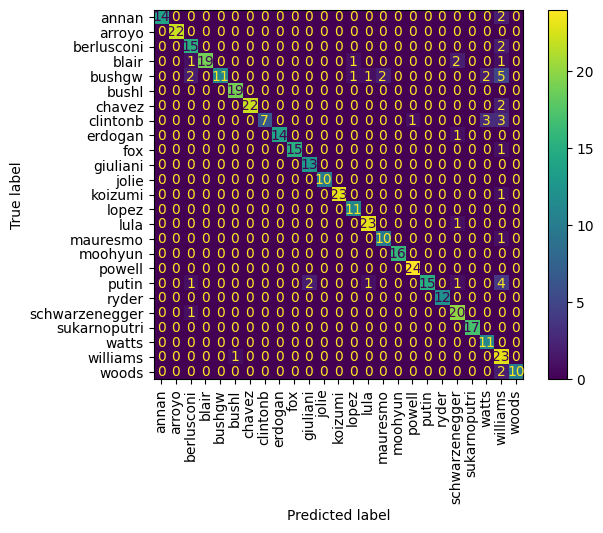

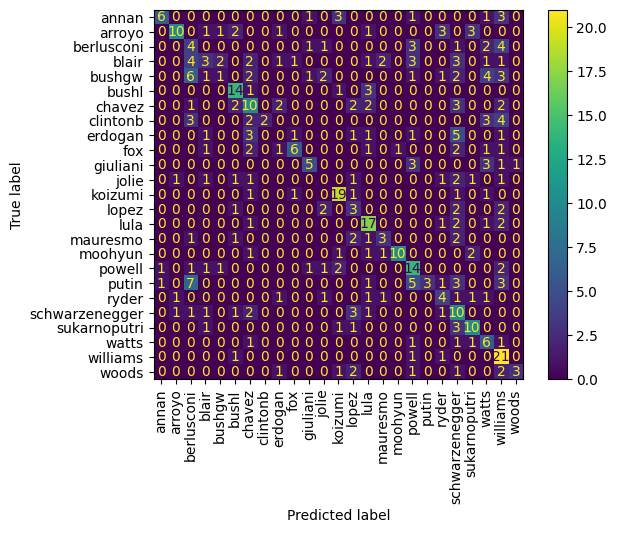

In [16]:
train_labels, train_predictions = get_labels(model, train_dataloader)
test_labels, test_predictions = get_labels(model, test_dataloader)

print("train error:", f"{classification_error(train_labels, train_predictions):.4f}")
print("test error", f"{classification_error(test_labels, test_predictions):.4f}")

display_confusion_matrix(train_labels, train_predictions, display_labels=LFWUtils.LABELS)
display_confusion_matrix(test_labels, test_predictions, display_labels=LFWUtils.LABELS)

### Re-Train with Evaluation

To make sure our model didn't overfit the training data, we should keep an eye on the evaluation function during training.

Let's re-initialize our model and optimizer and re-train our network:

In [17]:
model = nn.Linear(x_train.shape[1], len(y_train.unique()))

learning_rate = 1e-6
optim = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

loss_fn = nn.CrossEntropyLoss()

In [18]:
for e in range(32):
  for imgs, labels in train_dataloader:
    optim.zero_grad()
    labels_pred = model(imgs)
    loss = loss_fn(labels_pred, labels)
    loss.backward()
    optim.step()

  if e % 4 == 3:
    train_labels, train_predictions = get_labels(model, train_dataloader)
    test_labels, test_predictions = get_labels(model, test_dataloader)
    train_error = classification_error(train_labels, train_predictions)
    test_error = classification_error(test_labels, test_predictions)
    print(f"Epoch: {e} loss: {loss.item():.4f}, train error: {train_error:.4f}, test error: {test_error:.4f}")

Epoch: 3 loss: 80.3930, train error: 0.8607, test error: 0.8973
Epoch: 7 loss: 44.1857, train error: 0.6854, test error: 0.8128
Epoch: 11 loss: 20.7104, train error: 0.4674, test error: 0.6735
Epoch: 15 loss: 4.6708, train error: 0.2562, test error: 0.6187
Epoch: 19 loss: 3.9267, train error: 0.1438, test error: 0.5502
Epoch: 23 loss: 3.1350, train error: 0.2270, test error: 0.5822
Epoch: 27 loss: 0.1958, train error: 0.0989, test error: 0.5594
Epoch: 31 loss: 1.1307, train error: 0.0652, test error: 0.5571


train error: 0.0652
test error 0.5571


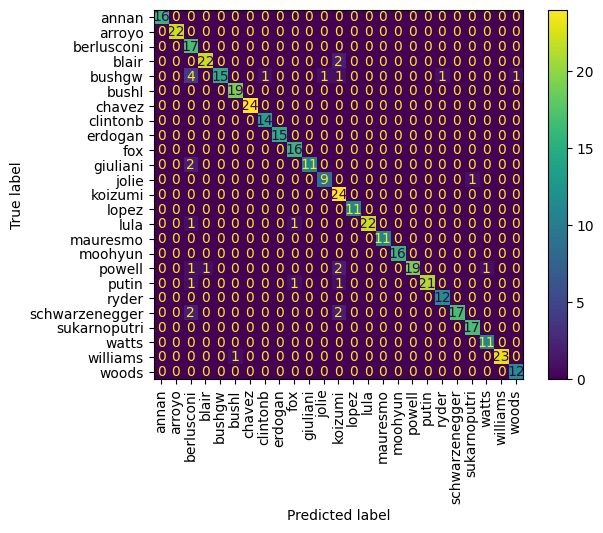

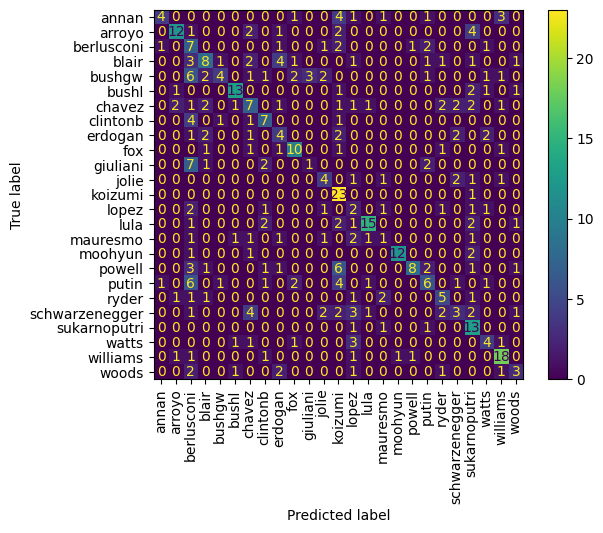

In [19]:
train_labels, train_predictions = get_labels(model, train_dataloader)
test_labels, test_predictions = get_labels(model, test_dataloader)

print("train error:", f"{classification_error(train_labels, train_predictions):.4f}")
print("test error", f"{classification_error(test_labels, test_predictions):.4f}")

display_confusion_matrix(train_labels, train_predictions, display_labels=LFWUtils.LABELS)
display_confusion_matrix(test_labels, test_predictions, display_labels=LFWUtils.LABELS)

### Interpretation

Is it overfitting ? Can we keep running the training cell ?

How low can we get our test error ?

### Add Layers

Maybe we can improve our classification by adding some hidden layers.

In [20]:
mdevice = "cuda" if torch.cuda.is_available() else "cpu"
model =  nn.Sequential(
  nn.Linear(x_train.shape[1], x_train.shape[1] // 2),
  nn.ReLU(),

  nn.Linear(x_train.shape[1] // 2, x_train.shape[1] // 16),
  nn.ReLU(),

  nn.Linear(x_train.shape[1] // 16, x_train.shape[1] // 32),
  nn.ReLU(),

  nn.Linear(x_train.shape[1] // 32, len(y_train.unique())),
).to(mdevice)

learning_rate = 1e-6
optim = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

loss_fn = nn.CrossEntropyLoss()

img, label = next(iter(train_dataloader))
out = model(img)

print("Input shape:", img.shape)
print("Output shape:", out.shape)

Input shape: torch.Size([128, 22100])
Output shape: torch.Size([128, 25])


In [ ]:
for e in range(32):
  for imgs, labels in train_dataloader:
    optim.zero_grad()
    labels_pred = model(imgs)
    loss = loss_fn(labels_pred, labels)
    loss.backward()
    optim.step()

  if e % 4 == 3:
    train_labels, train_predictions = get_labels(model, train_dataloader)
    test_labels, test_predictions = get_labels(model, test_dataloader)
    train_error = classification_error(train_labels, train_predictions)
    test_error = classification_error(test_labels, test_predictions)
    print(f"Epoch: {e} loss: {loss.item():.4f}, train error: {train_error:.4f}, test error: {test_error:.4f}")

Epoch: 3 loss: 5.1854, train error: 0.9303, test error: 0.9315
Epoch: 7 loss: 3.0437, train error: 0.8787, test error: 0.8973
Epoch: 11 loss: 2.7699, train error: 0.7685, test error: 0.8516


In [ ]:
train_labels, train_predictions = get_labels(model, train_dataloader)
test_labels, test_predictions = get_labels(model, test_dataloader)

print("train error:", f"{classification_error(train_labels, train_predictions):.4f}")
print("test error", f"{classification_error(test_labels, test_predictions):.4f}")

display_confusion_matrix(train_labels, train_predictions, display_labels=LFWUtils.LABELS)
display_confusion_matrix(test_labels, test_predictions, display_labels=LFWUtils.LABELS)

### Interpretation

The result is mostly the same, which is not surprising.

We did add layers, but the network didn't need any extra neurons to do well on the training data.

It needs help with the testing data, or, another way to say this is: it needs help generalizing without memorizing.

### Make It Harder

Neural network models can seem simple to explain in a general sense: they're long and wide computation graphs made up of simple operations that have been tuned to achieve a specific task. Once they're training, or trained, their details and specificities are a little less easy to describe. It's hard to know exactly what each neuron is doing, and what part of the computation they are responsible for. We can train the same network, with the same parameters, using the same input data, and end up with wildly different results.

This is one reason why it's hard to debug a network when it doesn't seem to be learning properly, or when it starts to overfit and memorize the training data. Which neurons do we tune ?

One common situation that can lead to overfitting is when a network ends up with parameters that make it perform well on the training data without really activating all of its neurons. This is usually what is happening if adding layers to a network doesn't improve its performance.

One set of strategies for improving neural network training in these cases involves making the training process harder than it has to be. It's like we're challenging the neural network to learn more than it has, so that later it has an easier time with the regular data.

#### Dropout

One simple technique to achieve this is to add `Dropout` layers to our network. A `Dropout` layer is a layer of neurons that don't perform any mathematical operation, but are selectively dropped out of the network randomly during training. This has the effect of randomly changing the network's architecture during training and preventing the network from becoming too reliant on specific neurons. Instead, it encourages the network to learn more robust features by activating more diverse sets of neurons.

<img src="./imgs/dropout.jpg" width="800px"/>

#### Activation Normalization

Another technique that is used to keep our neural networks from memorizing data has to do with the range of the values that get passed between its inner layers.

Input data coming into the network is most likely normalized, but after the first layer, the network weights might really change the distribution of the data as it flows through the network. Moreover, individual batches with different input value distributions can bias the network towards certain goals.

<img src="./imgs/norm_activation.jpg" width="720px"/>

#### Batch Normalization

One way to handle these situations is to normalize the data as it passes through the network. Batch Normalization is the process of normalizing the activations of our network by using the mean and standard deviation of an activation neuron across a batch. The result is that the activations between batches become more similar. Batch normalization is dependent on batch size, so it's not effective for small batches.

<img src="./imgs/norm_batch.jpg" width="720px"/>

#### Layer Normalization

Another form of inner-network normalization can be added to make sure no individual layer overpowers the network with activation values that are too large or too small.

Layer Normalization scales activations using the mean and standard deviation of all activations across a layer. It's effective for sequence models like RNNs and Transformers, and for scenarios with small batch sizes, and doesn't require a large batch to get a good estimate for mean and standard deviation. 

<img src="./imgs/norm_layer.jpg" width="720px"/>

In [ ]:
model =  nn.Sequential(
  nn.Dropout(0.35),
  nn.Linear(x_train.shape[1], x_train.shape[1] // 2),
  nn.BatchNorm1d( x_train.shape[1] // 2),
  nn.ReLU(),
  # nn.LayerNorm(x_train.shape[1] // 2),

  nn.Dropout(0.35),
  nn.Linear(x_train.shape[1] // 2, x_train.shape[1] // 16),
  nn.BatchNorm1d(x_train.shape[1] // 16),
  nn.ReLU(),
  # nn.LayerNorm(x_train.shape[1] // 16),

  nn.Dropout(0.35),
  nn.Linear(x_train.shape[1] // 16, x_train.shape[1] // 32),
  nn.BatchNorm1d(x_train.shape[1] // 32),
  nn.ReLU(),
  # nn.LayerNorm(x_train.shape[1] // 32),

  nn.Dropout(0.35),
  nn.Linear(x_train.shape[1] // 32, len(y_train.unique())),
).to(mdevice)

# lr := [1e-4, 1e-2]
learning_rate = 5e-3
optim = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

loss_fn = nn.CrossEntropyLoss()

img, label = next(iter(train_dataloader))
out = model(img)

print("Input shape:", img.shape)
print("Output shape:", out.shape)

In [ ]:
for e in range(32):
  model.train()
  for imgs, labels in train_dataloader:
    optim.zero_grad()
    labels_pred = model(imgs)
    loss = loss_fn(labels_pred, labels)
    loss.backward()
    optim.step()

  if e % 4 == 3:
    train_labels, train_predictions = get_labels(model, train_dataloader)
    test_labels, test_predictions = get_labels(model, test_dataloader)
    train_error = classification_error(train_labels, train_predictions)
    test_error = classification_error(test_labels, test_predictions)
    print(f"Epoch: {e} loss: {loss.item():.4f}, train error: {train_error:.4f}, test error: {test_error:.4f}")

### Interpretation

The train and test eval function diverged, but both keep decreasing, so this might be ok.

In the end, the network seems capable of learning for longer and while the classification error for the test dataset doesn't keep up with the error in the train dataset, it does perform better.

In [ ]:
train_labels, train_predictions = get_labels(model, train_dataloader)
test_labels, test_predictions = get_labels(model, test_dataloader)

print("train error", f"{classification_error(train_labels, train_predictions):.4f}")
print("test error", f"{classification_error(test_labels, test_predictions):.4f}")

display_confusion_matrix(train_labels, train_predictions, display_labels=LFWUtils.LABELS)
display_confusion_matrix(test_labels, test_predictions, display_labels=LFWUtils.LABELS)